# AKI - early/delayed renal treatment

*import libraries*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.formula.api import ols

from scipy import stats
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import metrics

In [2]:
# import data
aki_data = pd.read_csv('aki_icu.csv')

In [3]:
aki_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2110 entries, 0 to 2109
Columns: 198 entries, subject_id to gcs_unable
dtypes: float64(170), int64(16), object(12)
memory usage: 3.2+ MB


In [4]:
# rename columns, if necessary
# changing all column names to lower case, and remove special characters and spacing.
aki_data.columns = aki_data.columns.str.lower()
aki_data.columns = aki_data.columns.str.replace(' |/','_')
aki_data.columns

<ipython-input-4-11ac1132c921>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  aki_data.columns = aki_data.columns.str.replace(' |/','_')


Index(['subject_id', 'hadm_id', 'stay_id', 'weight', 'weight_min',
       'weight_max', 'charttime_aki', 'creat_low_past_7day',
       'creat_low_past_48hr', 'creat',
       ...
       'spo2_mean', 'glucose_min.2', 'glucose_max.2', 'glucose_mean',
       'urineoutput', 'gcs_min', 'gcs_motor', 'gcs_verbal', 'gcs_eyes',
       'gcs_unable'],
      dtype='object', length=198)

In [5]:
pd.set_option('display.max_columns', 100)
aki_data.head()

,subject_id,hadm_id,stay_id,weight,weight_min,weight_max,charttime_aki,creat_low_past_7day,creat_low_past_48hr,creat,aki_stage_creat,uo_rt_6hr,uo_rt_12hr,uo_rt_24hr,aki_stage_uo,aki_stage,kigoord,new_event_flag,kigoord_flag,charttime_rrt,dialysis_present,dialysis_active,dialysis_type,rrtorder,delay_rrt,gender,dod,admittime,dischtime,los_hospital,admission_age,ethnicity,hospital_expire_flag,hospstay_seq,first_hosp_stay,icu_intime,icu_outtime,los_icu,icustay_seq,first_icu_stay,lactate_min,lactate_max,ph_min,ph_max,so2_min,so2_max,po2_min,po2_max,pco2_min,pco2_max,...,alp_min,alp_max,ast_min,ast_max,amylase_min,amylase_max,bilirubin_total_min,bilirubin_total_max,bilirubin_direct_min,bilirubin_direct_max,bilirubin_indirect_min,bilirubin_indirect_max,ck_cpk_min,ck_cpk_max,ck_mb_min,ck_mb_max,ggt_min,ggt_max,ld_ldh_min,ld_ldh_max,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,sbp_mean,dbp_min,dbp_max,dbp_mean,mbp_min,mbp_max,mbp_mean,resp_rate_min,resp_rate_max,resp_rate_mean,temperature_min.1,temperature_max.1,temperature_mean,spo2_min,spo2_max,spo2_mean,glucose_min.2,glucose_max.2,glucose_mean,urineoutput,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable
0,19518348,24328934,30041848,104.50,102.0,107.0,07-04-26 4:00,NaN,NaN,NaN,NaN,0.4657,0.6891,0.6891,1.0,1,8,1,1,16-04-26 14:25,1,1,IHD,1,1,M,24-04-26,06-04-26 17:21,24-04-26 9:00,17.652083,66.262081,UNKNOWN,1,1,t,06-04-26 17:22,24-04-26 13:11,17.83,1,t,1.3,1.3,7.41,7.42,98.0,98.0,90.0,147.0,39.0,40.0,...,61.0,61.0,44.0,44.0,NaN,NaN,0.3,0.3,NaN,NaN,NaN,NaN,484.0,644.0,15.0,23.0,NaN,NaN,485.0,485.0,66.0,138.0,89.625000,95.0,152.0,132.500000,48.0,91.0,68.5000,59.0,98.0,83.090909,18.0,27.0,21.673077,36.83,38.11,37.405000,93.0,99.0,96.909091,172.0,321.0,257.500000,2895.0,10,5.0,1.0,4.0,0
1,18070922,27400972,30078723,100.00,100.0,100.0,30-06-47 8:00,NaN,NaN,NaN,NaN,0.4334,0.6007,0.9219,1.0,1,32,1,1,05-07-47 19:15,1,1,CRRT,1,1,M,NaN,28-06-47 21:56,30-07-47 14:40,31.697222,70.489938,BLACK/AFRICAN AMERICAN,0,1,t,28-06-47 21:59,30-07-47 15:03,31.71,1,t,1.2,1.2,7.35,7.37,NaN,NaN,99.0,99.0,38.0,40.0,...,36.0,37.0,12.0,13.0,NaN,NaN,0.6,0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.0,96.0,84.208333,95.0,116.0,107.500000,49.0,83.5,56.4600,62.0,157.0,74.019231,12.0,23.0,17.134615,36.72,37.56,36.978000,92.0,99.0,96.680000,106.0,140.0,123.666667,2400.0,3,1.0,1.0,1.0,0
2,17414351,23018977,30254621,98.95,85.0,103.6,14-09-79 12:12,NaN,NaN,NaN,NaN,0.0000,0.0000,0.0000,3.0,3,4,1,1,14-09-79 12:23,1,1,CRRT,1,0,M,NaN,14-09-79 0:06,03-01-80 18:15,111.756250,37.700917,UNKNOWN,0,1,t,14-09-79 0:07,17-10-79 19:59,33.83,1,t,1.2,2.5,7.34,7.42,93.0,93.0,36.0,85.0,29.0,36.0,...,351.0,351.0,104.0,104.0,NaN,NaN,36.3,36.3,26.7,26.7,NaN,NaN,36.0,36.0,4.0,4.0,NaN,NaN,331.0,331.0,71.0,93.0,80.956522,82.0,118.0,101.958333,36.0,63.0,52.4375,51.0,78.0,67.541667,12.0,36.0,20.000000,35.50,36.70,36.132143,92.0,100.0,95.250000,114.0,228.0,152.625000,10.0,6,4.0,1.0,1.0,0
3,17555267,21215796,30326472,105.70,104.0,107.4,20-12-28 5:38,NaN,NaN,NaN,NaN,2.7933,2.7933,0.2665,3.0,3,6,1,1,24-12-28 18:20,1,1,CRRT,1,1,F,26-12-28,19-12-28 5:54,26-12-28 0:00,6.754167,59.967156,WHITE,1,1,t,19-12-28 5:58,27-12-28 0:08,7.76,1,t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,133.0,164.0,162.0,189.0,NaN,NaN,3.0,3.3,NaN,NaN,NaN,NaN,1011.0,1131.0,14.0,16.0,NaN,NaN,374.0,378.0,78.0,97.0,87.521739,75.0,161.0,108.000000,34.0,131.0,56.4000,54.0,139.0,70.700000,17.0,32.0,24.086957,36.39,37.00,36.776667,88.0,100.0,96.478261,47.0,134.0,102.714286,425.0,13,6.0,5.0,2.0,0
4,18571406,23198317,30341422,69.00,66.7,71.3,23-01-80 9:00,NaN,NaN,NaN,NaN,0.4909,0.6812,0.6812,1.0,1,7,1,1,23-01-80 14:00,1,1,IHD,1,0,M,NaN,23-01-80 2:04,28-01-80 15:00,5.538889,79.060470,WHITE,0,1,t,23-01-80 2:05,24-01-80 0:04,0.92,1,t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,277.0,277.0,6.0,6.0,NaN,NaN,NaN,NaN,74.0,100.0,90.318182,113.0,161.0,140.800000,26.0,134.0,71.8500,60.0,141.0,88.285714,17.0,25.0,21.000000,36.33,

**missing data**

In [6]:
pd.set_option('display.max_rows', 200)
pd.isna(aki_data).sum()

subject_id                      0
hadm_id                         0
stay_id                         0
weight                          9
weight_min                      9
weight_max                      9
charttime_aki                   0
creat_low_past_7day           752
creat_low_past_48hr           778
creat                         752
aki_stage_creat               752
uo_rt_6hr                    1344
uo_rt_12hr                   1344
uo_rt_24hr                   1344
aki_stage_uo                 1344
aki_stage                       0
kigoord                         0
new_event_flag                  0
kigoord_flag                    0
charttime_rrt                   0
dialysis_present                0
dialysis_active                 0
dialysis_type                  90
rrtorder                        0
delay_rrt                       0
gender                          0
dod                          1225
admittime                       0
dischtime                       0
los_hospital  

In [7]:
# double checking this happens in same rows?
print(np.array_equal(aki_data.index[aki_data['sodium_min'].isnull()] , aki_data.index[aki_data['sodium_max'].isnull()]))

True


In [8]:
np.array_equal(aki_data.index[aki_data['weight_min'].isnull()], aki_data.index[aki_data['weight'].isnull()])

True

In [9]:
# uneven sample
aki_data['delay_rrt'].value_counts()

1    1720
0     390
Name: delay_rrt, dtype: int64

**drop columns not of interest**

In [10]:
# clinician's input
aki_data.drop(columns=['weight_min', 'weight_max',
                       'charttime_aki',
                       'creat_low_past_7day','creat_low_past_48hr','creat','aki_stage_creat',
                       'uo_rt_6hr','uo_rt_12hr','uo_rt_24hr','aki_stage_uo',
                       'kigoord','new_event_flag','kigoord_flag',
                       'charttime_rrt',
                       'dialysis_present','dialysis_active','dialysis_type',
                       'rrtorder',
                       'dod',
                       'admittime','dischtime','los_hospital',
                       'hospital_expire_flag','hospstay_seq','first_hosp_stay',
                       'icu_intime','icu_outtime','los_icu',
                       'icustay_seq', 'first_icu_stay',
                       'lactate_min',
                       'so2_max',
                       'po2_max',
                       'aado2_min','aado2_max',
                       'aado2_calc_min',
                       'pao2fio2ratio_min', 'pao2fio2ratio_max',
                       'baseexcess_max',
                       'bicarbonate_min','bicarbonate_max',
                       'totalco2_min', 'totalco2_max',
                       'hematocrit_min','hematocrit_max',
                       'hemoglobin_min','hemoglobin_max',
                       'carboxyhemoglobin_min','carboxyhemoglobin_max',
                       'methemoglobin_min','methemoglobin_max',
                       'temperature_min','temperature_max',
                       'chloride_min','chloride_max',
                       'calcium_min','calcium_max',
                       'glucose_min','glucose_max',
                       'potassium_min','potassium_max',
                       'sodium_min','sodium_max',
                       'globulin_min','globulin_max',
                       'total_protein_min','total_protein_max',
                       'atypical_lymphocytes_min','atypical_lymphocytes_max',
                       'bands_min','bands_max',
                       'immature_granulocytes_min','immature_granulocytes_max',
                       'metamyelocytes_min','metamyelocytes_max',
                       'nrbc_min','nrbc_max',
                       'd_dimer_min','d_dimer_max',
                       'thrombin_min','thrombin_max',
                       'inr_min',
                       'pt_min',
                       'ptt_min',
                       'alt_min',
                       'alp_min',
                       'ast_min',
                       'amylase_min','amylase_max',
                       'bilirubin_total_min',
                       'bilirubin_direct_min','bilirubin_direct_max',
                       'bilirubin_indirect_min','bilirubin_indirect_max',
                       'ck_cpk_min',
                       'ck_mb_min',
                       'ggt_min','ggt_max',
                       'ld_ldh_min',
                       'heart_rate_min','heart_rate_max',
                       'sbp_min','sbp_max',
                       'dbp_min','dbp_max',
                       'mbp_min','mbp_max',
                       'resp_rate_min','resp_rate_max',
                       'temperature_min.1','temperature_max.1',
                       'spo2_min','spo2_max',
                       'glucose_min.2','glucose_max.2',
                       'gcs_motor','gcs_verbal','gcs_eyes','gcs_unable'],inplace=True)

In [11]:
pd.set_option('display.max_rows', 85)
aki_data.info()
# 78 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2110 entries, 0 to 2109
Data columns (total 78 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   subject_id           2110 non-null   int64  
 1   hadm_id              2110 non-null   int64  
 2   stay_id              2110 non-null   int64  
 3   weight               2101 non-null   float64
 4   aki_stage            2110 non-null   int64  
 5   delay_rrt            2110 non-null   int64  
 6   gender               2110 non-null   object 
 7   admission_age        2110 non-null   float64
 8   ethnicity            2110 non-null   object 
 9   lactate_max          1639 non-null   float64
 10  ph_min               1762 non-null   float64
 11  ph_max               1762 non-null   float64
 12  so2_min              1029 non-null   float64
 13  po2_min              1762 non-null   float64
 14  pco2_min             1762 non-null   float64
 15  pco2_max             1762 non-null   f

**missing data**

In [12]:
pd.isna(aki_data).sum()

subject_id                0
hadm_id                   0
stay_id                   0
weight                    9
aki_stage                 0
delay_rrt                 0
gender                    0
admission_age             0
ethnicity                 0
lactate_max             471
ph_min                  348
ph_max                  348
so2_min                1081
po2_min                 348
pco2_min                348
pco2_max                348
aado2_calc_max          774
baseexcess_min          348
hematocrit_min.1          4
hematocrit_max.1          4
hemoglobin_min.1          6
hemoglobin_max.1          6
platelets_min             4
platelets_max             4
wbc_min                   5
wbc_max                   5
albumin_min             863
albumin_max             863
aniongap_min              3
aniongap_max              3
bicarbonate_min.1         3
bicarbonate_max.1         3
bun_min                   3
bun_max                   3
calcium_min.1            73
calcium_max.1       

**drop columns due to too many missing data**

Since there are 2110 rows, any columns with >125 (approx 5%) missing rows will be dropped.

In [13]:
aki_data = aki_data[aki_data.columns[aki_data.isnull().sum()<125]] 

In [14]:
aki_data.shape

(2110, 47)

47 columns left left.

In [15]:
# aki_data.drop(columns=['lactate_max',
#                        'ph_min','ph_max',
#                        'so2_min',
#                        'po2_min','po2_max',
#                        'aado2_calc_max',
#                        'baseexcess_min',
#                        'albumin_min','albumin_max',
#                        'basophils_abs_min','basophils_abs_max',
#                        'eosinophils_abs_min','eosinophils_abs_max',
#                        'lymphocytes_abs_min','lymphocytes_abs_max',
#                        'monocytes_abs_min','monocytes_abs_max',
#                        'neutrophils_abs_min','neutrophils_abs_max',
#                        'fibrinogen_min','fibrinogen_max',
#                        'alt_max',
#                        'alp_max',
#                        'ast_max',
#                        'bilirubin_total_max',
#                        'ck_cpk_max','ck_mb_max',
#                        'ld_ldh_max',
#                        'urineoutput'])

In [16]:
pd.isnull(aki_data).sum()

subject_id             0
hadm_id                0
stay_id                0
weight                 9
aki_stage              0
delay_rrt              0
gender                 0
admission_age          0
ethnicity              0
hematocrit_min.1       4
hematocrit_max.1       4
hemoglobin_min.1       6
hemoglobin_max.1       6
platelets_min          4
platelets_max          4
wbc_min                5
wbc_max                5
aniongap_min           3
aniongap_max           3
bicarbonate_min.1      3
bicarbonate_max.1      3
bun_min                3
bun_max                3
calcium_min.1         73
calcium_max.1         73
chloride_min.1         3
chloride_max.1         3
creatinine_min         3
creatinine_max         3
glucose_min.1          6
glucose_max.1          6
sodium_min.1           3
sodium_max.1           3
potassium_min.1        3
potassium_max.1        3
inr_max              107
pt_max               107
ptt_max              116
heart_rate_mean       10
sbp_mean              23


In [17]:
# drop rows
aki_data.dropna(inplace=True)

In [18]:
aki_data.shape

(1786, 47)

1786 rows left.

In [19]:
# double checking
pd.isnull(aki_data).sum()

subject_id           0
hadm_id              0
stay_id              0
weight               0
aki_stage            0
delay_rrt            0
gender               0
admission_age        0
ethnicity            0
hematocrit_min.1     0
hematocrit_max.1     0
hemoglobin_min.1     0
hemoglobin_max.1     0
platelets_min        0
platelets_max        0
wbc_min              0
wbc_max              0
aniongap_min         0
aniongap_max         0
bicarbonate_min.1    0
bicarbonate_max.1    0
bun_min              0
bun_max              0
calcium_min.1        0
calcium_max.1        0
chloride_min.1       0
chloride_max.1       0
creatinine_min       0
creatinine_max       0
glucose_min.1        0
glucose_max.1        0
sodium_min.1         0
sodium_max.1         0
potassium_min.1      0
potassium_max.1      0
inr_max              0
pt_max               0
ptt_max              0
heart_rate_mean      0
sbp_mean             0
dbp_mean             0
mbp_mean             0
resp_rate_mean       0
temperature

In [20]:
aki_data.head()

,subject_id,hadm_id,stay_id,weight,aki_stage,delay_rrt,gender,admission_age,ethnicity,hematocrit_min.1,hematocrit_max.1,hemoglobin_min.1,hemoglobin_max.1,platelets_min,platelets_max,wbc_min,wbc_max,aniongap_min,aniongap_max,bicarbonate_min.1,bicarbonate_max.1,bun_min,bun_max,calcium_min.1,calcium_max.1,chloride_min.1,chloride_max.1,creatinine_min,creatinine_max,glucose_min.1,glucose_max.1,sodium_min.1,sodium_max.1,potassium_min.1,potassium_max.1,inr_max,pt_max,ptt_max,heart_rate_mean,sbp_mean,dbp_mean,mbp_mean,resp_rate_mean,temperature_mean,spo2_mean,glucose_mean,gcs_min
0,19518348,24328934,30041848,104.50,1,1,M,66.262081,UNKNOWN,31.4,31.9,11.3,11.3,246.0,247.0,11.2,11.2,20.0,23.0,23.0,24.0,109.0,114.0,8.7,9.5,106.0,114.0,3.0,3.1,172.0,317.0,146.0,154.0,3.9,4.1,1.3,14.6,47.5,89.625000,132.500000,68.5000,83.090909,21.673077,37.405000,96.909091,257.500000,10
1,18070922,27400972,30078723,100.00,1,1,M,70.489938,BLACK/AFRICAN AMERICAN,34.0,34.2,11.3,11.4,185.0,186.0,12.1,13.5,14.0,16.0,20.0,21.0,36.0,41.0,7.5,7.7,103.0,104.0,1.1,1.1,106.0,140.0,134.0,135.0,4.4,4.8,1.3,13.9,25.0,84.208333,107.500000,56.4600,74.019231,17.134615,36.978000,96.680000,123.666667,3
2,17414351,23018977,30254621,98.95,3,0,M,37.700917,UNKNOWN,27.1,29.4,9.9,10.4,185.0,252.0,22.4,31.1,26.0,30.0,15.0,18.0,40.0,53.0,7.4,10.2,73.0,76.0,7.8,10.5,121.0,228.0,118.0,119.0,3.3,3.8,2.6,27.5,36.0,80.956522,101.958333,52.4375,67.541667,20.000000,36.132143,95.250000,152.625000,6
3,17555267,21215796,30326472,105.70,3,1,F,59.967156,WHITE,25.0,30.9,8.1,10.1,70.0,107.0,7.6,14.5,11.0,13.0,19.0,23.0,15.0,16.0,7.5,7.8,106.0,110.0,1.1,1.2,47.0,127.0,140.0,141.0,3.2,4.0,2.6,28.4,51.3,87.521739,108.000000,56.4000,70.700000,24.086957,36.776667,96.478261,102.714286,13
4,18571406,23198317,30341422,69.00,1,0,M,79.060470,WHITE,38.0,38.0,13.2,13.2,262.0,262.0,10.8,10.8,18.0,18.0,21.0,21.0,19.0,19.0,9.4,9.4,106.0,106.0,1.3,1.3,126.0,126.0,141.0,141.0,3.7,3.7,1.2,13.8,35.6,90.318182,140.800000,71.8500,88.285714,21.000000,36.620000,95.782609,124.000000,15


In [21]:
aki_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1786 entries, 0 to 2109
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   subject_id         1786 non-null   int64  
 1   hadm_id            1786 non-null   int64  
 2   stay_id            1786 non-null   int64  
 3   weight             1786 non-null   float64
 4   aki_stage          1786 non-null   int64  
 5   delay_rrt          1786 non-null   int64  
 6   gender             1786 non-null   object 
 7   admission_age      1786 non-null   float64
 8   ethnicity          1786 non-null   object 
 9   hematocrit_min.1   1786 non-null   float64
 10  hematocrit_max.1   1786 non-null   float64
 11  hemoglobin_min.1   1786 non-null   float64
 12  hemoglobin_max.1   1786 non-null   float64
 13  platelets_min      1786 non-null   float64
 14  platelets_max      1786 non-null   float64
 15  wbc_min            1786 non-null   float64
 16  wbc_max            1786 

## categorical data

In [22]:
# should be categorical
aki_data[['subject_id','hadm_id','stay_id']] = aki_data[['subject_id','hadm_id','stay_id']].astype(str)

In [23]:
# select only categorical columns
nom_aki = aki_data.select_dtypes(include='object').copy()

In [24]:
nom_aki.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1786 entries, 0 to 2109
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   subject_id  1786 non-null   object
 1   hadm_id     1786 non-null   object
 2   stay_id     1786 non-null   object
 3   gender      1786 non-null   object
 4   ethnicity   1786 non-null   object
dtypes: object(5)
memory usage: 83.7+ KB


In [25]:
# no duplicates
nom_aki['subject_id'].duplicated().sum()

0

In [26]:
nom_aki['hadm_id'].duplicated().sum()

0

In [27]:
nom_aki['stay_id'].duplicated().sum()

0

In [28]:
nom_aki['gender'].value_counts()

M    1077
F     709
Name: gender, dtype: int64

In [29]:
nom_aki['delay_rrt'] = aki_data['delay_rrt']

C:\Users\USER\anaconda3\envs\dsi24\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


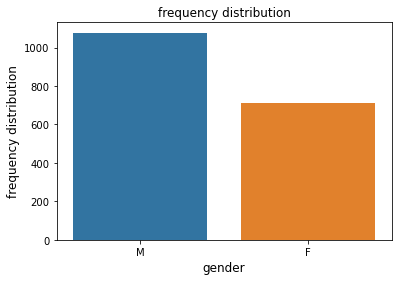

In [30]:
gender_count=nom_aki['gender'].value_counts()
sns.barplot(gender_count.index,gender_count.values);
plt.title('frequency distribution')
plt.ylabel('frequency distribution', fontsize=12)
plt.xlabel('gender', fontsize=12);

In [31]:
# convert gender to numerical
nom_aki['gender']=nom_aki['gender'].apply(lambda x: 1 if x=='M' else 0)

In [32]:
nom_aki['gender'].value_counts()

1    1077
0     709
Name: gender, dtype: int64

In [33]:
nom_aki['ethnicity'].unique()

array(['UNKNOWN', 'BLACK/AFRICAN AMERICAN', 'WHITE', 'UNABLE TO OBTAIN',
       'HISPANIC/LATINO', 'OTHER', 'AMERICAN INDIAN/ALASKA NATIVE',
       'ASIAN'], dtype=object)

In [34]:
nom_aki['ethnicity'].value_counts()

WHITE                            1010
UNKNOWN                           285
BLACK/AFRICAN AMERICAN            230
OTHER                              88
HISPANIC/LATINO                    83
ASIAN                              43
UNABLE TO OBTAIN                   41
AMERICAN INDIAN/ALASKA NATIVE       6
Name: ethnicity, dtype: int64

In [35]:
nom_aki['ethnicity'] = nom_aki['ethnicity'].str.lower()
nom_aki['ethnicity'] = nom_aki['ethnicity'].str.replace(' |/','_')

<ipython-input-35-9b6547cef298>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  nom_aki['ethnicity'] = nom_aki['ethnicity'].str.replace(' |/','_')


In [36]:
# whites has the biggest percentage
max(nom_aki['ethnicity'].value_counts())/len(nom_aki)

0.5655095184770437

In [37]:
nom_aki['ethnicity'].unique()

array(['unknown', 'black_african_american', 'white', 'unable_to_obtain',
       'hispanic_latino', 'other', 'american_indian_alaska_native',
       'asian'], dtype=object)

In [38]:
ethnic_label = {'unknown': 'other', 
                'black_african_american': 'black', 
                'white': 'white',
                'unable_to_obtain': 'other', 
               'hispanic_latino': 'latino', 
                'other': 'other', 
                'american_indian_alaska_native': 'native', 
                'asian': 'asian' }

In [39]:
# grouped 'unknown','other','unable to obtain' as 'other'
nom_aki['ethnicity'] = nom_aki['ethnicity'].map(ethnic_label)

C:\Users\USER\anaconda3\envs\dsi24\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


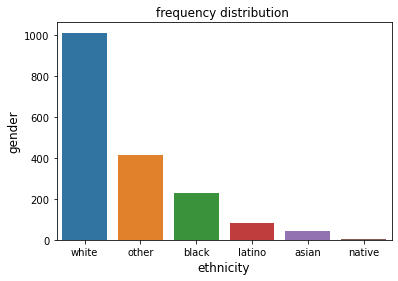

In [40]:
ethnicity_count=nom_aki['ethnicity'].value_counts()
sns.barplot(ethnicity_count.index,ethnicity_count.values);
plt.title('frequency distribution ')
plt.ylabel('gender', fontsize=12)
plt.xlabel('ethnicity', fontsize=12);

In [41]:
nom_aki['ethnicity'].value_counts()

white     1010
other      414
black      230
latino      83
asian       43
native       6
Name: ethnicity, dtype: int64

## continuous data

In [42]:
num_aki = aki_data.select_dtypes(include=['int64','float64']).copy()

In [43]:
num_aki.head()

,weight,aki_stage,delay_rrt,admission_age,hematocrit_min.1,hematocrit_max.1,hemoglobin_min.1,hemoglobin_max.1,platelets_min,platelets_max,wbc_min,wbc_max,aniongap_min,aniongap_max,bicarbonate_min.1,bicarbonate_max.1,bun_min,bun_max,calcium_min.1,calcium_max.1,chloride_min.1,chloride_max.1,creatinine_min,creatinine_max,glucose_min.1,glucose_max.1,sodium_min.1,sodium_max.1,potassium_min.1,potassium_max.1,inr_max,pt_max,ptt_max,heart_rate_mean,sbp_mean,dbp_mean,mbp_mean,resp_rate_mean,temperature_mean,spo2_mean,glucose_mean,gcs_min
0,104.50,1,1,66.262081,31.4,31.9,11.3,11.3,246.0,247.0,11.2,11.2,20.0,23.0,23.0,24.0,109.0,114.0,8.7,9.5,106.0,114.0,3.0,3.1,172.0,317.0,146.0,154.0,3.9,4.1,1.3,14.6,47.5,89.625000,132.500000,68.5000,83.090909,21.673077,37.405000,96.909091,257.500000,10
1,100.00,1,1,70.489938,34.0,34.2,11.3,11.4,185.0,186.0,12.1,13.5,14.0,16.0,20.0,21.0,36.0,41.0,7.5,7.7,103.0,104.0,1.1,1.1,106.0,140.0,134.0,135.0,4.4,4.8,1.3,13.9,25.0,84.208333,107.500000,56.4600,74.019231,17.134615,36.978000,96.680000,123.666667,3
2,98.95,3,0,37.700917,27.1,29.4,9.9,10.4,185.0,252.0,22.4,31.1,26.0,30.0,15.0,18.0,40.0,53.0,7.4,10.2,73.0,76.0,7.8,10.5,121.0,228.0,118.0,119.0,3.3,3.8,2.6,27.5,36.0,80.956522,101.958333,52.4375,67.541667,20.000000,36.132143,95.250000,152.625000,6
3,105.70,3,1,59.967156,25.0,30.9,8.1,10.1,70.0,107.0,7.6,14.5,11.0,13.0,19.0,23.0,15.0,16.0,7.5,7.8,106.0,110.0,1.1,1.2,47.0,127.0,140.0,141.0,3.2,4.0,2.6,28.4,51.3,87.521739,108.000000,56.4000,70.700000,24.086957,36.776667,96.478261,102.714286,13
4,69.00,1,0,79.060470,38.0,38.0,13.2,13.2,262.0,262.0,10.8,10.8,18.0,18.0,21.0,21.0,19.0,19.0,9.4,9.4,106.0,106.0,1.3,1.3,126.0,126.0,141.0,141.0,3.7,3.7,1.2,13.8,35.6,90.318182,140.800000,71.8500,88.285714,21.000000,36.620000,95.782609,124.000000,15


In [44]:
# remove the .1
num_aki.columns = num_aki.columns.str.replace('.1','')
num_aki.columns

<ipython-input-44-c42b6853c451>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  num_aki.columns = num_aki.columns.str.replace('.1','')


Index(['weight', 'aki_stage', 'delay_rrt', 'admission_age', 'hematocrit_min',
       'hematocrit_max', 'hemoglobin_min', 'hemoglobin_max', 'platelets_min',
       'platelets_max', 'wbc_min', 'wbc_max', 'aniongap_min', 'aniongap_max',
       'bicarbonate_min', 'bicarbonate_max', 'bun_min', 'bun_max',
       'calcium_min', 'calcium_max', 'chloride_min', 'chloride_max',
       'creatinine_min', 'creatinine_max', 'glucose_min', 'glucose_max',
       'sodium_min', 'sodium_max', 'potassium_min', 'potassium_max', 'inr_max',
       'pt_max', 'ptt_max', 'heart_rate_mean', 'sbp_mean', 'dbp_mean',
       'mbp_mean', 'resp_rate_mean', 'temperature_mean', 'spo2_mean',
       'glucose_mean', 'gcs_min'],
      dtype='object')

In [45]:
num_aki.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1786 entries, 0 to 2109
Data columns (total 42 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   weight            1786 non-null   float64
 1   aki_stage         1786 non-null   int64  
 2   delay_rrt         1786 non-null   int64  
 3   admission_age     1786 non-null   float64
 4   hematocrit_min    1786 non-null   float64
 5   hematocrit_max    1786 non-null   float64
 6   hemoglobin_min    1786 non-null   float64
 7   hemoglobin_max    1786 non-null   float64
 8   platelets_min     1786 non-null   float64
 9   platelets_max     1786 non-null   float64
 10  wbc_min           1786 non-null   float64
 11  wbc_max           1786 non-null   float64
 12  aniongap_min      1786 non-null   float64
 13  aniongap_max      1786 non-null   float64
 14  bicarbonate_min   1786 non-null   float64
 15  bicarbonate_max   1786 non-null   float64
 16  bun_min           1786 non-null   float64


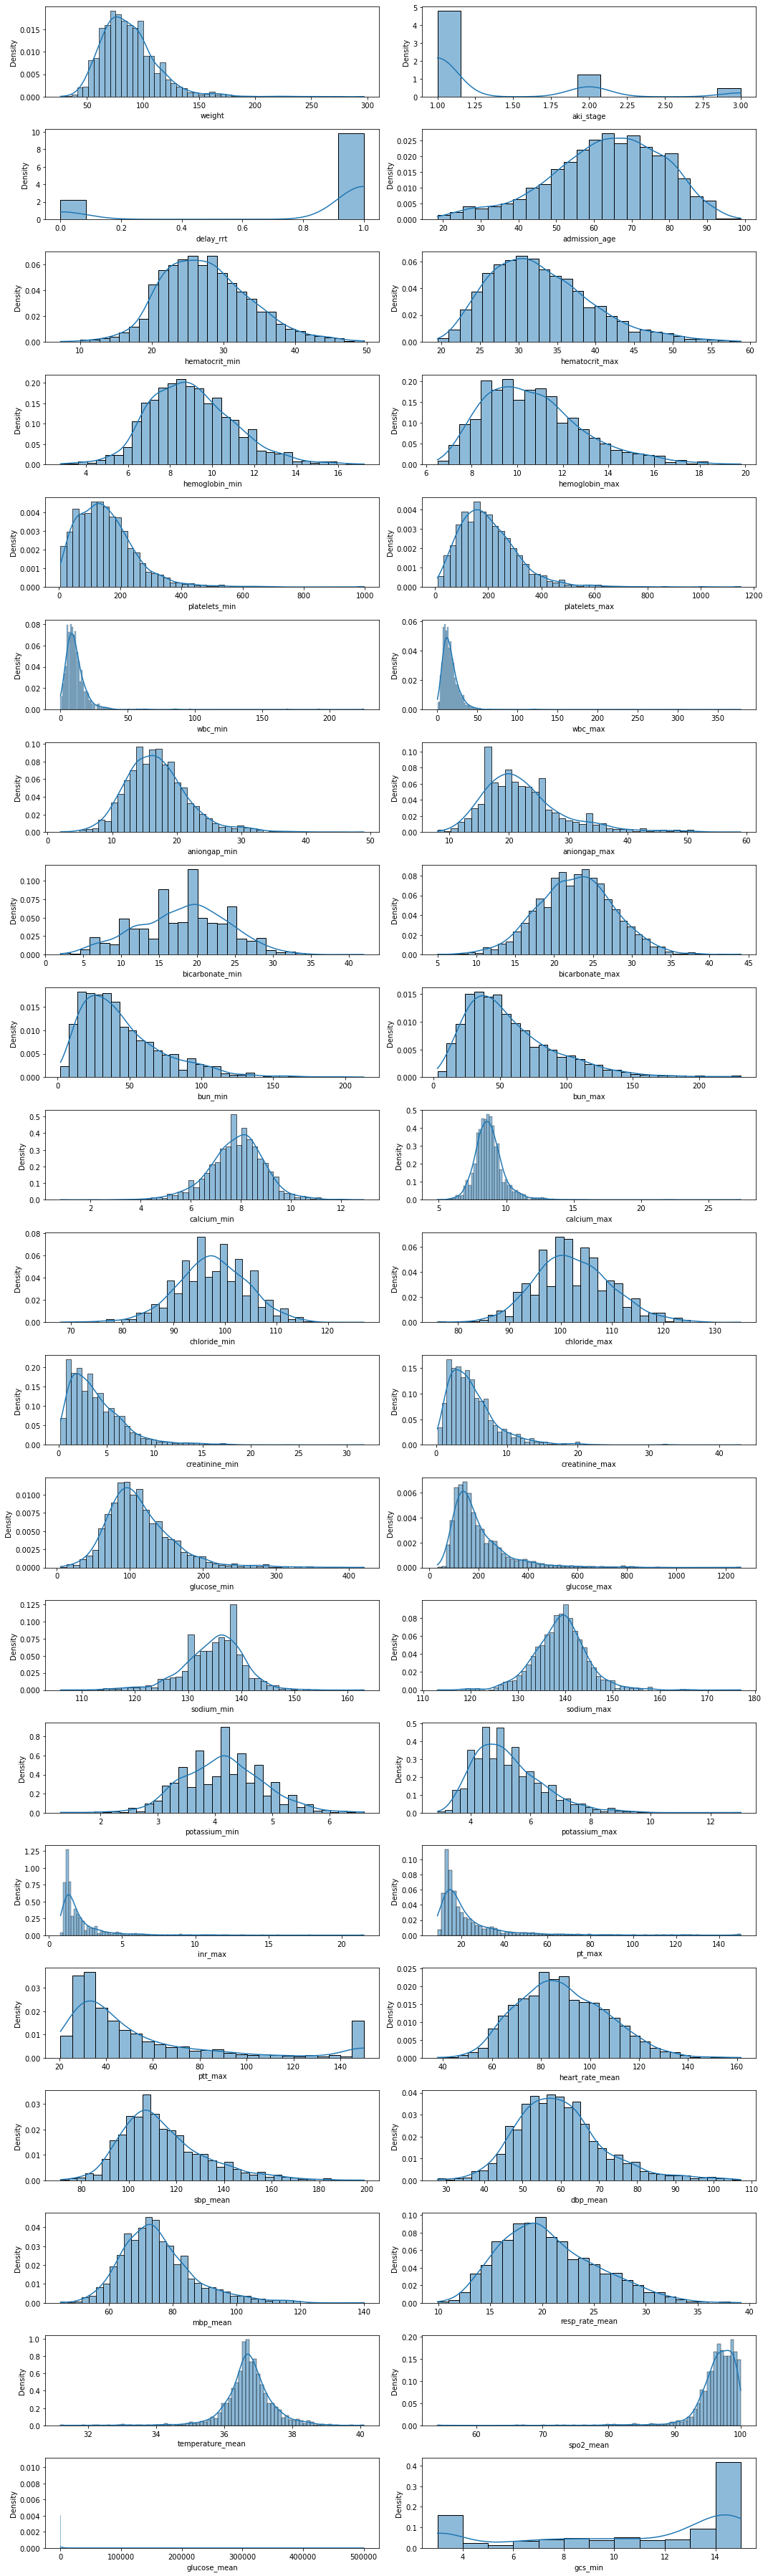

In [46]:
# plot overview distributions of numerical variables
# determining number of columns
ncols = 2
cols = num_aki.columns

# determining number of rows
nrows = round(int(np.ceil(len(num_aki.columns)) / (1.0*ncols)))

fig, axes = plt.subplots(nrows, ncols, figsize=(15,50))
axes = axes.ravel()

for col, ax in zip(cols, axes):
    sns.histplot(data=num_aki[col], kde=True, stat='density', ax=ax)

plt.tight_layout();

Most of these variables are not normally distributed. 
<br>'delay_rrt', our outcome variable is discrete [0,1].
<br> 'aki_stage' is ordinal.

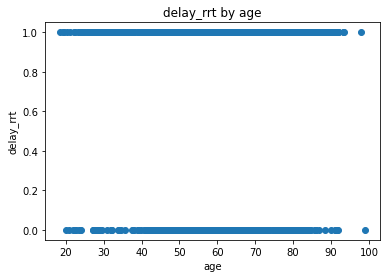

In [47]:
plt.scatter(num_aki['admission_age'] ,num_aki['delay_rrt']);
plt.title('delay_rrt by age')
plt.xlabel('age')
plt.ylabel('delay_rrt');

**glucose_mean**

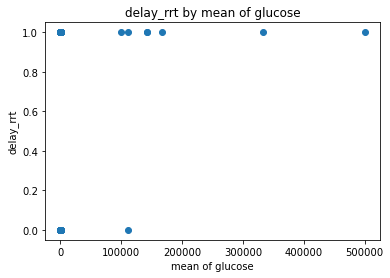

In [48]:
plt.scatter(num_aki['glucose_mean'] ,num_aki['delay_rrt']);
plt.title('delay_rrt by mean of glucose')
plt.xlabel('mean of glucose')
plt.ylabel('delay_rrt');

In [49]:
# glucose_mean looks suspicious
num_aki['glucose_mean'].describe()

count      1786.000000
mean       1051.200171
std       16100.410753
min          62.000000
25%         110.062500
50%         136.333333
75%         178.333333
max      500037.500000
Name: glucose_mean, dtype: float64

C:\Users\USER\anaconda3\envs\dsi24\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


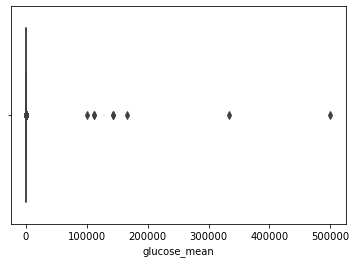

In [50]:
# check outliers for glucose_mean
sns.boxplot(num_aki['glucose_mean']);

In [51]:
# remove outliers in glucose_mean
num_aki = num_aki[num_aki['glucose_mean']<3000]

**weight**

In [52]:
# weight looks suspicious
num_aki['weight'].describe() 

count    1778.000000
mean       87.692438
std        26.077158
min        26.400000
25%        70.000000
50%        84.100000
75%        99.975000
max       296.800000
Name: weight, dtype: float64

C:\Users\USER\anaconda3\envs\dsi24\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


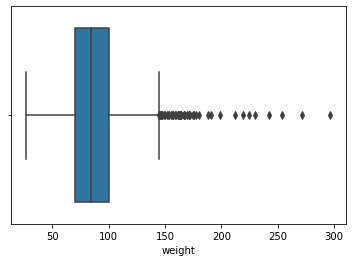

In [53]:
# check outliers for weight
sns.boxplot(num_aki['weight']);

There are lots of outliers in 'weight', but how do we remove them? Is it possible for someone to be 300kg? For a mostly caucasion dataset? 

**wbc_min**

In [54]:
num_aki['wbc_min'].describe() 

count    1778.000000
mean       11.277390
std        10.857185
min         0.100000
25%         6.400000
50%         9.600000
75%        13.500000
max       225.300000
Name: wbc_min, dtype: float64

C:\Users\USER\anaconda3\envs\dsi24\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


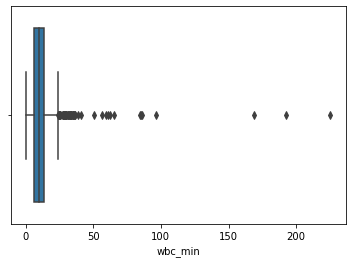

In [55]:
# check outliers for wbc_min
sns.boxplot(num_aki['wbc_min']);

**wbc_max**

In [56]:
num_aki['wbc_max'].describe() 

count    1778.000000
mean       16.804556
std        16.657864
min         0.100000
25%         9.500000
50%        13.900000
75%        20.075000
max       378.300000
Name: wbc_max, dtype: float64

C:\Users\USER\anaconda3\envs\dsi24\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


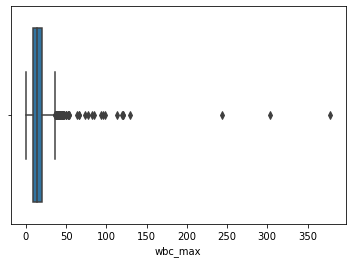

In [57]:
# check outliers for wbc_max
sns.boxplot(num_aki['wbc_max']);

**calcium_max**

In [58]:
num_aki['calcium_max'].describe() 

count    1778.000000
mean        8.748088
std         1.209249
min         4.900000
25%         8.100000
50%         8.600000
75%         9.200000
max        27.400000
Name: calcium_max, dtype: float64

C:\Users\USER\anaconda3\envs\dsi24\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


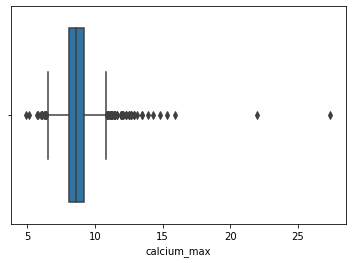

In [59]:
# check outliers for calcium_max
sns.boxplot(num_aki['calcium_max']);

**creatinine_min**

In [60]:
num_aki['creatinine_min'].describe() 

count    1778.000000
mean        3.921822
std         2.961649
min         0.200000
25%         1.800000
50%         3.200000
75%         5.200000
max        31.800000
Name: creatinine_min, dtype: float64

C:\Users\USER\anaconda3\envs\dsi24\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


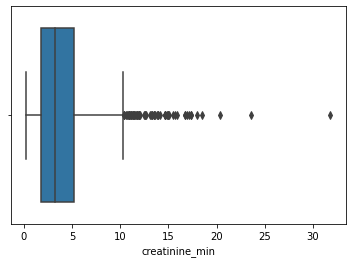

In [61]:
# check outliers for creatinine_min
sns.boxplot(num_aki['creatinine_min']);

**creatinine_max**

In [62]:
num_aki['creatinine_max'].describe() 

count    1778.000000
mean        5.082565
std         3.631448
min         0.200000
25%         2.600000
50%         4.200000
75%         6.600000
max        43.000000
Name: creatinine_max, dtype: float64

C:\Users\USER\anaconda3\envs\dsi24\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


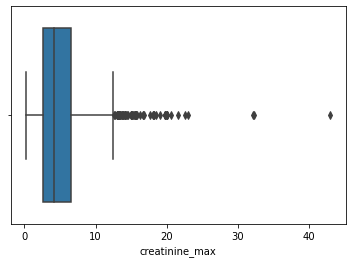

In [63]:
# check outliers for calcium_max
sns.boxplot(num_aki['creatinine_max']);

**inr_max**

In [64]:
num_aki['inr_max'].describe() 

count    1778.000000
mean        2.091676
std         1.670371
min         0.800000
25%         1.200000
50%         1.500000
75%         2.300000
max        21.500000
Name: inr_max, dtype: float64

C:\Users\USER\anaconda3\envs\dsi24\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


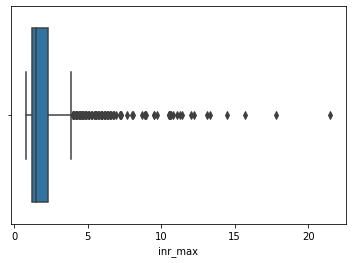

In [65]:
# check outliers for inr_max
sns.boxplot(num_aki['inr_max']);

**pt_max**

In [66]:
num_aki['pt_max'].describe() 

count    1778.000000
mean       22.285996
std        16.177237
min         8.900000
25%        13.600000
50%        16.600000
75%        24.100000
max       150.000000
Name: pt_max, dtype: float64

C:\Users\USER\anaconda3\envs\dsi24\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


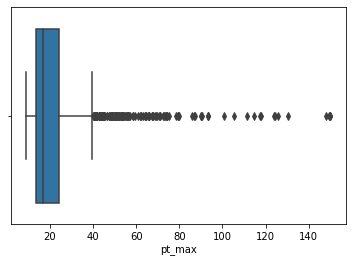

In [67]:
# check outliers for pt_max
sns.boxplot(num_aki['pt_max']);

**spo2_mean**

In [68]:
num_aki['spo2_mean'].describe() 

count    1778.000000
mean       96.470320
std         3.324450
min        54.095238
25%        95.392332
50%        97.000000
75%        98.500000
max       100.000000
Name: spo2_mean, dtype: float64

C:\Users\USER\anaconda3\envs\dsi24\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


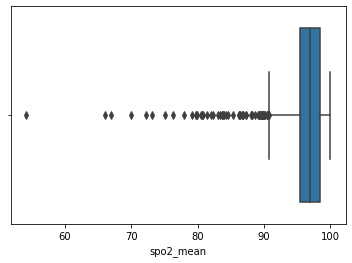

In [69]:
# check outliers for spo2_mean
sns.boxplot(num_aki['spo2_mean']);

<br> Outliers, in general, are rare by definition. However, if there are many outliers, this might imply that something interesting is going on, which may affect or create a relationship between the variable and the predicted target (delay_rrt). 

In [70]:
# sns.pairplot(num_aki,hue='delay_rrt')

# EDA

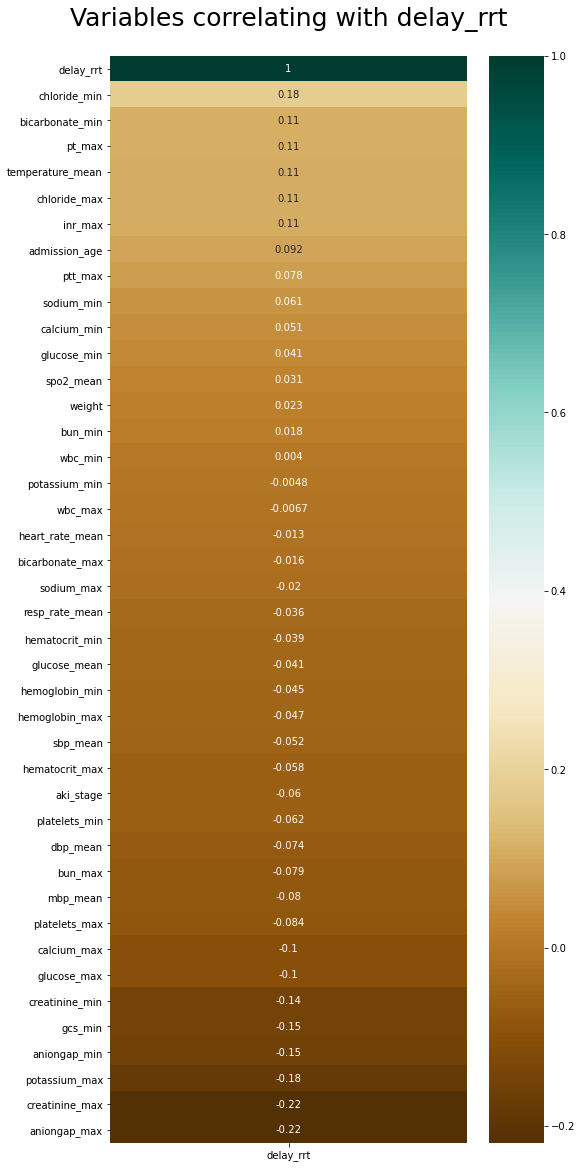

In [71]:
# find correlation
# only plots continuous, discrete and converted ordinal variables
plt.figure(figsize=(8, 20))
ax = sns.heatmap(num_aki.corr(method='spearman')[['delay_rrt']].sort_values(by='delay_rrt', ascending=False), annot=True, cmap='BrBG')
ax.set_title('Variables correlating with delay_rrt', fontdict={'fontsize':25}, pad=30);

In [72]:
# clearer dataframe
# for corr >= 0.05
aki_corr = num_aki.corr(method='spearman').abs()
aki_corr.loc[aki_corr['delay_rrt']>=0.05,['delay_rrt']].sort_values(by=['delay_rrt'],ascending=False)

,delay_rrt
delay_rrt,1.000000
aniongap_max,0.219092
creatinine_max,0.215134
potassium_max,0.178538
chloride_min,0.176414
aniongap_min,0.153351
gcs_min,0.145449
creatinine_min,0.143292
bicarbonate_min,0.111833
pt_max,0.109496


export dataset

In [73]:
# data.to_csv('aki_features.csv',index=False)